# 🧠 RECONHECIMENTO DE EMOÇÕES FACIAIS
### *Uma Análise Comparativa com Abordagens Convencionais*

---

## 📝 Autoria  
**Autor:**  
🔹 Igor Cenzi dos Santos Alves  
📧 *igor.alves@sou.fae.br*  

**Orientadora:**  
🔹 Profª. Cristiane Yae Mi Imamura  
📧 *cristiane.imamura@prof.fae.br*  

**Instituição:**  
🏫 FAE Centro Universitário  

---

## 🎯 Objetivo  
Desenvolver um modelo de reconhecimento de emoções faciais com performance otimizada, comparando a abordagem com redes neurais profundas (VGG19) contra métodos convencionais de machine learning.

**Principais métricas de avaliação:**  
- Acurácia  
- Precisão  
- Recall  
- F1-Score  

---

## 📦 Materiais & Recursos  
### Bases de Dados  
🔹 **FER-2013**  
[![Kaggle](https://img.shields.io/badge/-Kaggle-20BEFF?logo=kaggle&logoColor=white)](https://www.kaggle.com/datasets/msambare/fer2013)  
- 35,887 imagens de expressões faciais  
- 7 classes de emoções (Raiva, Nojo, Medo, Feliz, Neutro, Triste, Surpreso)  
- Resolução 48×48 pixels (grayscale)  

### Modelos  
🔹 **VGG19** (Transfer Learning)  
[![Keras](https://img.shields.io/badge/-Keras-D00000?logo=keras&logoColor=white)](https://keras.io/api/applications/vgg/)  
- Arquitetura CNN pré-treinada no ImageNet  
- 19 camadas profundas  

---

## 📌 Checklist de Atividades  

| Status | Tarefa | Detalhes |
|--------|--------|----------|
| ✅ | Importação de bibliotecas | `TensorFlow`, `Keras`, `OpenCV`, `Pandas` |
| ✅ | Download do dataset FER-2013 | Carregamento via Kaggle API |
| ✅ | Leitura dos dados de treino e teste | Kaggle |
| ✅ | Exploração do dataset | Análise de distribuição de classes |
| ✅ | Limpeza de dados | Removendo imagens sem rostos |
| ✅ | Testes iniciais VGG19 e Resnet50 | Baseline sem pré-processamento |
| ✅ | Visualização de métricas | Gráficos de acurácia/loss |
| ✅ | Conclusões parciais | Comparativo inicial |
| 🔄 | Explorar novos modelos | Testes com novos modelos |
| 🔄 | Melhorias | Aplicar técnicas de processamento de imagens para melhorar o dataset |

---

## 🔍 Próximos Passos  
1. **Pré-processamento avançado**  
   - Equalização de histograma  
   - Data augmentation (rotação, flip)  

2. **Fine-tuning do VGG19**  
   - Congelamento de camadas  
   - Ajuste de hiperparâmetros  

3. **Benchmark** contra:  
   - SVM
   - KNN 
   - CNN customizada  


## 1. Importação de bibliotecas que serão utilizadas no projeto

In [6]:
import os
import shutil
import warnings
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import cv2
import dlib
from imutils import face_utils
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')

## 2. Download do dataset FER-2013

O download é feito utilizando a biblioteca kagglehub e as imagens são salvas no diretório de destino DESTINATION_PATH

In [12]:
DESTINATION_PATH = "./fer2013"

In [16]:
import os
import zipfile

dataset = "msambare/fer2013"
zip_file = "fer2013.zip"
output_dir = "fer2013"

if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)
    exit_code = os.system(f"kaggle datasets download -d {dataset}")
    
    if exit_code == 0:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        if os.path.exists(zip_file):
            os.remove(zip_file)

## 3. Carregando os dados baixados para a memória

Com os dados salvos, o próximo passo é fazer a leitura para a memória e adicionar a label dos dados

In [13]:
TRAIN_PATH = os.path.join(DESTINATION_PATH, "train")
TEST_PATH = os.path.join(DESTINATION_PATH, "test")

def load_images_and_labels(DATA_PATH):
    images = []
    labels = []
    class_names = sorted(os.listdir(DATA_PATH))
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(DATA_PATH, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(label_map[class_name])

    return np.array(images), np.array(labels), label_map

X_train, y_train, label_map = load_images_and_labels(TRAIN_PATH)
X_test, y_test, _ = load_images_and_labels(TEST_PATH)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)
print("Labels mapeadas:", label_map)

Train: (28709, 48, 48, 3) (28709,)
Test: (7178, 48, 48, 3) (7178,)
Labels mapeadas: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


# 4. Explorando o dataset

## 4.1. Visualizando algumas imagens de cada uma das 7 classes do dataset

### Angry:

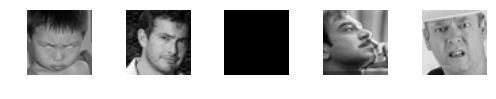

### Disgust:

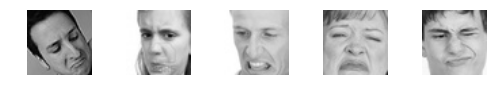

### Fear:

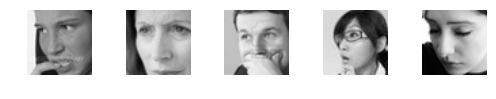

### Happy:

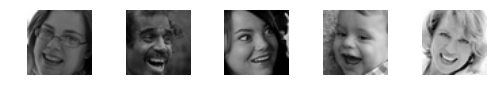

### Neutral:

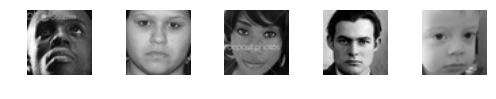

### Sad:

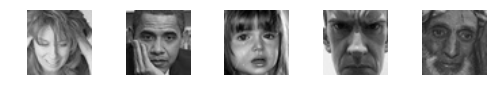

### Surprise:

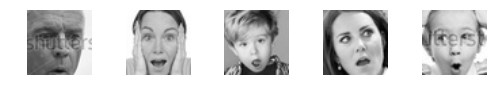

In [14]:
inv_label_map = {v: k for k, v in label_map.items()}

samples_per_class = 5
classes = sorted(np.unique(y_train))
selected_images = {label: [] for label in classes}

for img, label in zip(X_train, y_train):
    if len(selected_images[label]) < samples_per_class:
        selected_images[label].append(img)
    if all(len(imgs) == samples_per_class for imgs in selected_images.values()):
        break

for label in classes:
    emotion_name = inv_label_map[label].capitalize()
    display(Markdown(f"### {emotion_name}:"))

    fig, axes = plt.subplots(1, samples_per_class, figsize=(samples_per_class * 1.4, 1.4))
    for i in range(samples_per_class):
        img_rgb = cv2.cvtColor(selected_images[label][i], cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb, interpolation='bilinear')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## 🕵️‍♂️ Análise Exploratória - Limitações do Dataset

Durante a inspeção inicial do **FER-2013**, identificamos um desafio crítico para modelos de reconhecimento facial:

### Problema: Amostras Não-Úteis
🔴 **Caso exemplar** (imagem abaixo):  
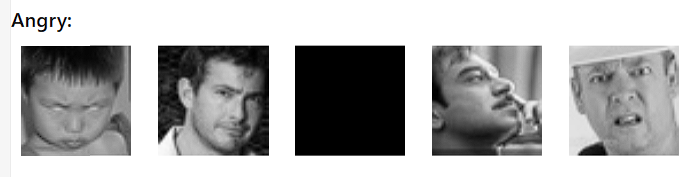  
*Figura 1: Instância do dataset sem conteúdo facial discernível - rótulo original: "Angry"*

## 📊 4.2 Análise de Distribuição de Classes: Treino

### Distribuição Percentual Comparativa

**Principais Observações:**
 **Desbalanceamento Característico**  
   - Classe predominante: Happy (25.13%)  
   - Classes minoritárias:  
     - Disgust (1.54%)  
     - Surprise (11.05%)  

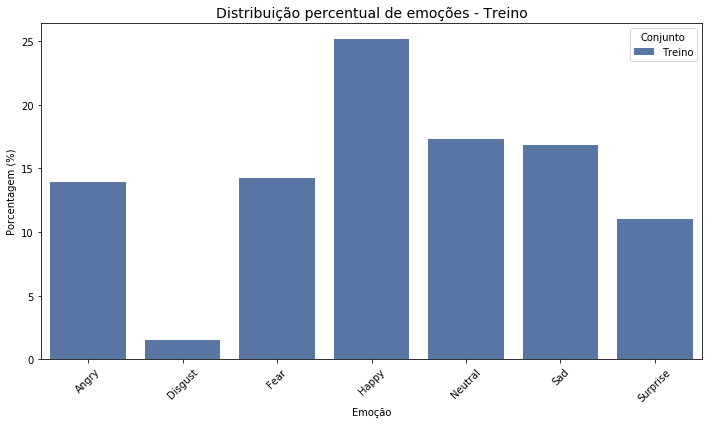

In [15]:
def get_distribution(labels):
    count_series = pd.Series(labels).value_counts().sort_index()
    count_df = pd.DataFrame({
        'Emoção': [inv_label_map[i].capitalize() for i in count_series.index],
        'Quantidade': count_series.values,
    })
    total = count_df['Quantidade'].sum()
    count_df['Porcentagem'] = (count_df['Quantidade'] / total * 100).round(2)
    return count_df

df_train = get_distribution(y_train)

df_train['Conjunto'] = 'Treino'

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_train,
    x='Emoção',
    y='Porcentagem',
    hue='Conjunto',
    palette=['#4C72B0', '#55A868']
)

plt.title("Distribuição percentual de emoções - Treino", fontsize=14)
plt.ylabel("Porcentagem (%)")
plt.xlabel("Emoção")
plt.xticks(rotation=45)
plt.legend(title="Conjunto")
plt.tight_layout()
plt.show()

# ⚠️ Impactos do Desbalanceamento de Classes

## Principais Problemas

### 1. 📈 Acurácia Ilusória
- Modelos atingem alta acurácia apenas prevendo classes majoritárias
- Exemplo: 90% de acurácia quando 90% dos dados são de uma só classe

### 2. 🎯 Viés de Predição
- Classes minoritárias são sistematicamente negligenciadas
- Baixo recall para emoções raras

### 3. 📊 Distorção Métrica
- Métricas globais (F1-macro) mascaram desempenho ruim em classes específicas
- Precisão desigual entre classes

## 5. Limpando o dataset

Conforme observado na etapa anterior, algumas imagens estão completamente pretas, ou seja, sem nenhum rosto para detectar. A função abaixo executa a limpeza desse dataset em memória.

In [10]:
from tqdm import tqdm

def remove_black_images(images, labels):
    valid_indices = []
    progress_bar = tqdm(enumerate(images), total=len(images), desc="Removendo imagens pretas")
    
    for i, img in progress_bar:
        if np.any(img > 0):
            valid_indices.append(i)

    filtered_images = images[valid_indices]
    filtered_labels = labels[valid_indices]

    print(f"\nRemoção concluída. {len(filtered_images)}/{len(images)} imagens mantidas.")
    print(f"Distribuição das classes após remoção: {np.unique(filtered_labels, return_counts=True)}")

    return filtered_images, filtered_labels


In [11]:
X_train_filtered, y_train_filtered = remove_black_images(X_train, y_train)

Removendo imagens pretas: 100%|██████████| 28709/28709 [00:00<00:00, 87406.13it/s]



Remoção concluída. 28698/28709 imagens mantidas.
Distribuição das classes após remoção: (array([0, 1, 2, 3, 4, 5, 6]), array([3988,  436, 4097, 7214, 4964, 4829, 3170]))


In [12]:
qtd_removidas = X_train.shape[0] - X_train_filtered.shape[0]
print(f"Foram removidas {qtd_removidas} imagens.")

Foram removidas 11 imagens.


## 6. Pré-processamento de Imagens de treino para o VGG19

### 📌 **Objetivo**  
- Preparar as imagens do dataset para compatibilidade com a arquitetura VGG19, seguindo os mesmos padrões utilizados no treinamento original no ImageNet.
- Para as labels, é utilizado a técnica de OneHot Encoding, a qual transforma uma saída única em um array com todas as possíveis classes, indicando 1 para a classe que é a correta e 0 para as demais.

In [22]:
def prepare_images(images):
    processed_images = []
    
    for img in images:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
        
        img_processed = preprocess_input(img_resized)
        processed_images.append(img_processed)
    
    return np.array(processed_images)

In [23]:
X_train_preprocessed = prepare_images(X_train_filtered)
y_train_preprocessed = to_categorical(y_train_filtered)

## 7. Definição de modelo inicial VGG19

In [11]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 7
BATCH_SIZE = 64
EPOCHS = 20

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             'Precision', 
             'Recall']
)

model_vgg16.summary()

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3),
    ModelCheckpoint('best_vgg19_model_basic.keras', monitor='accuracy', save_best_only=True)
]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             

 Total params: 139,598,919 (532.53 MB)

 Trainable params: 119,574,535 (456.14 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

## Treinando o modelo

In [12]:
history = model.fit(
    X_train_preprocessed, y_train_preprocessed,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 4086s 11s/step - Precision: 0.4235 - Recall: 0.3812 - accuracy: 0.4066 - loss: 4.5040 - val_Precision: 0.0362 - val_Recall: 0.0209 - val_accuracy: 0.0763 - val_loss: 6.4890 - learning_rate: 1.0000e-04
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 4115s 11s/step - Precision: 0.7269 - Recall: 0.5595 - accuracy: 0.6451 - loss: 0.9891 - val_Precision: 0.1139 - val_Recall: 0.0770 - val_accuracy: 0.1322 - val_loss: 6.7496 - learning_rate: 1.0000e-04
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 4124s 11s/step - Precision: 0.8176 - Recall: 0.7045 - accuracy: 0.7578 - loss: 0.6840 - val_Precision: 0.1494 - val_Recall: 0.1089 - val_accuracy: 0.1570 - val_loss: 7.2028 - learning_rate: 1.0000e-04
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 4128s 12s/step - Precision: 0.8545 - Recall: 0.7839 - accuracy: 0.8182 - loss: 0.5377 - val_Precision: 0.0972 - val_Recall: 0.0810 - val_accuracy: 0.1082 - val_loss: 9.2024 - learning_rate: 1.0000e-04
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━

In [20]:
# Recarregar modelo salvo

model = tf.keras.models.load_model("best_vgg19_model_basic.keras")

## Avaliando o desempenho no conjunto de treino

In [26]:
def plot_metrics(y_true, y_pred):
    classes_emocao = list(label_map.keys())
    class_acc = {}

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print("Accuracy Score:  ", round(acc, 4))
    print("Precision Score: ", round(prec, 4))
    print("Recall Score:    ", round(rec, 4))
    print("F1 Score:        ", round(f1, 4))
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))
    
    for i, emotion in enumerate(classes_emocao):
        idx = np.where(y_true == i)[0]
        correct = np.sum(y_pred[idx] == y_true[idx])
        class_acc[emotion] = correct / len(idx)
    
    print('\nAcurácia por classe:')
    for emotion, acc in class_acc.items():
        print(f'- {emotion}: {acc:.2%}')

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes_emocao, 
                yticklabels=classes_emocao)
    plt.title('Matriz de Confusão - VGG19')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()

In [24]:
y_pred = model.predict(X_train_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train_preprocessed, axis=1)

897/897 ━━━━━━━━━━━━━━━━━━━━ 3806s 4s/step


Accuracy Score:   0.819
Precision Score:  0.7327
Recall Score:     0.7953
F1 Score:         0.7495

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3988
           1       0.97      0.99      0.98       436
           2       0.62      0.98      0.76      4097
           3       0.89      1.00      0.94      7214
           4       0.83      0.99      0.90      4964
           5       0.98      0.61      0.75      4829
           6       0.00      0.00      0.00      3170

    accuracy                           0.82     28698
   macro avg       0.73      0.80      0.75     28698
weighted avg       0.75      0.82      0.77     28698


Acurácia por classe:
- angry: 99.30%
- disgust: 98.85%
- fear: 98.49%
- happy: 99.97%
- neutral: 99.38%
- sad: 60.74%
- surprise: 0.00%


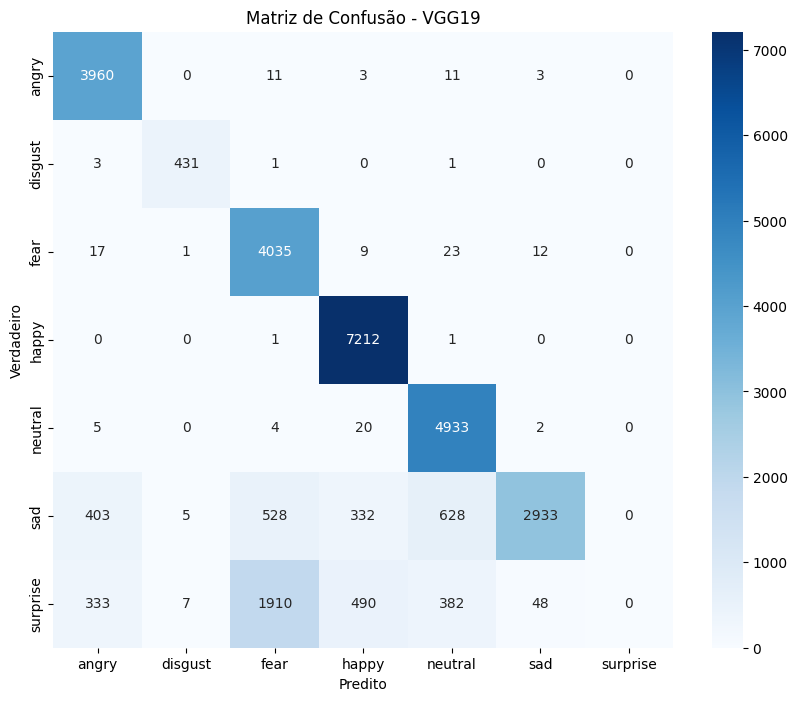

In [27]:
plot_metrics(y_true, y_pred_classes)

# Usando a ResNet50

In [11]:
def preprocess_image(img):
    img = tf.image.resize(img, [224, 224])
    img = tf.keras.applications.imagenet_utils.preprocess_input(
        img, mode='torch')
    return img

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)  # 7 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,693,063 (98.01 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_rn50

def prepare_images_resnet50(images):
    processed_images = []
    
    for img in images:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
        
        img_processed = preprocess_rn50(img_resized)
        processed_images.append(img_processed)
    
    return np.array(processed_images)

X_train_preprocessed_rn50 = prepare_images_resnet50(X_train_filtered)
y_train_preprocessed_rn50 = to_categorical(y_train_filtered)

In [15]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 7
BATCH_SIZE = 64
EPOCHS = 20

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3),
    ModelCheckpoint('best_resnet50_model_basic.keras', monitor='accuracy', save_best_only=True)
]

history = model.fit(
    X_train_preprocessed_rn50, y_train_preprocessed_rn50,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1300s 4s/step - accuracy: 0.3914 - loss: 1.6246 - val_accuracy: 0.0051 - val_loss: 5.4049 - learning_rate: 1.0000e-04
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1199s 3s/step - accuracy: 0.5328 - loss: 1.2415 - val_accuracy: 0.1111 - val_loss: 5.4945 - learning_rate: 1.0000e-04
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1184s 3s/step - accuracy: 0.5587 - loss: 1.1633 - val_accuracy: 0.0997 - val_loss: 5.6959 - learning_rate: 1.0000e-04
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1181s 3s/step - accuracy: 0.5821 - loss: 1.1033 - val_accuracy: 0.0625 - val_loss: 6.6253 - learning_rate: 1.0000e-04
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1188s 3s/step - accuracy: 0.6142 - loss: 1.0381 - val_accuracy: 0.0709 - val_loss: 6.4483 - learning_rate: 1.0000e-05
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1177s 3s/step - accuracy: 0.6219 - loss: 1.0198 - val_accuracy: 0.0758 - val_loss: 6.4028 - learning_rate: 1.0000e-05


In [17]:
y_preds_rn50 = model.predict(X_train_preprocessed_rn50)

897/897 ━━━━━━━━━━━━━━━━━━━━ 1205s 1s/step


In [18]:
y_pred_rn50_classes = np.argmax(y_preds_rn50, axis=1)
y_true_rn50 = np.argmax(y_train_preprocessed_rn50, axis=1)

Accuracy Score:   0.4326
Precision Score:  0.3447
Recall Score:     0.3324
F1 Score:         0.2789

Classification Report:

              precision    recall  f1-score   support

           0       0.39      0.37      0.38      3988
           1       0.00      0.00      0.00       436
           2       0.26      0.68      0.38      4097
           3       0.60      0.81      0.69      7214
           4       0.50      0.46      0.48      4964
           5       0.66      0.01      0.03      4829
           6       0.00      0.00      0.00      3170

    accuracy                           0.43     28698
   macro avg       0.34      0.33      0.28     28698
weighted avg       0.44      0.43      0.37     28698


Acurácia por classe:
- angry: 36.81%
- disgust: 0.00%
- fear: 67.95%
- happy: 80.65%
- neutral: 45.97%
- sad: 1.30%
- surprise: 0.00%


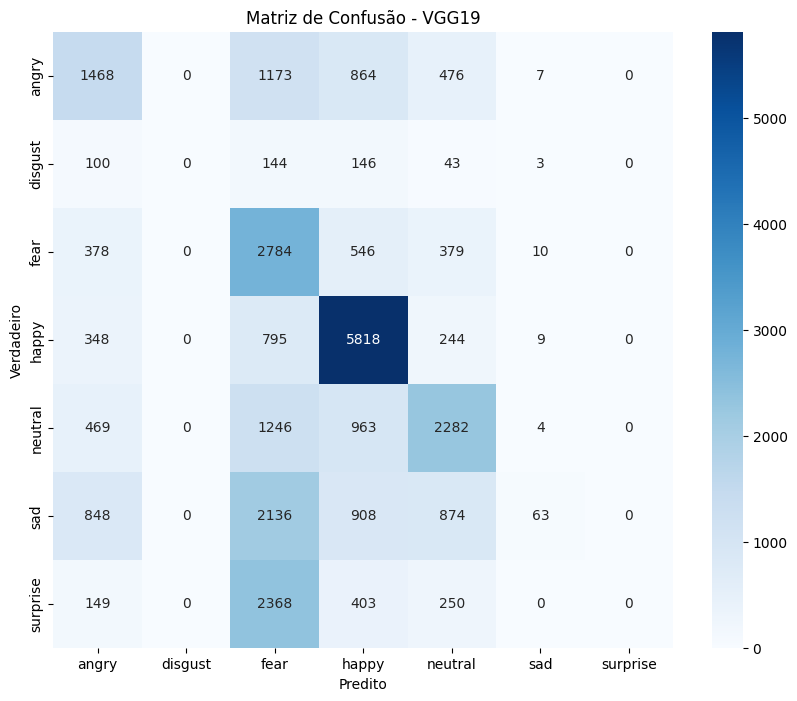

In [28]:
plot_metrics(y_true_rn50, y_pred_rn50_classes)

In [29]:
# Função para exibir as classes classificadas erradas
def show_images_with_classification_error(y_true, y_pred, X_data, classe_verdadeira, classe_predita, num_imgs=10):

    indices_erro = np.where((y_true == classe_verdadeira) & (y_pred == classe_predita))[0]
    indices_erro = indices_erro[:num_imgs]

    if len(indices_erro) == 0:
        print(f"Nenhuma imagem da classe {classe_verdadeira} foi classificada como {classe_predita}.")
        return

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices_erro):
        plt.subplot(1, len(indices_erro), i + 1)
        img = X_data[idx]
        img = img - np.min(img)
        img = img / np.max(img)
        plt.imshow(img)
        plt.title(f"True: {classe_verdadeira}\nPred: {classe_predita}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

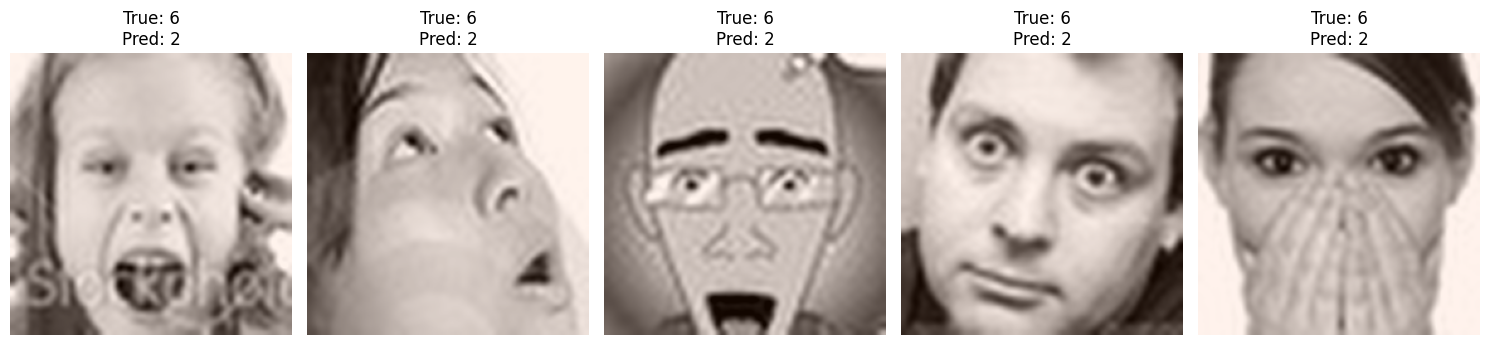

In [41]:
# Exibe os erros da classe "surprise" classificadas como "fear" do modelo VGG19
show_images_with_classification_error(y_train_filtered, y_pred_classes, X_train_preprocessed, 6, 2, 5)

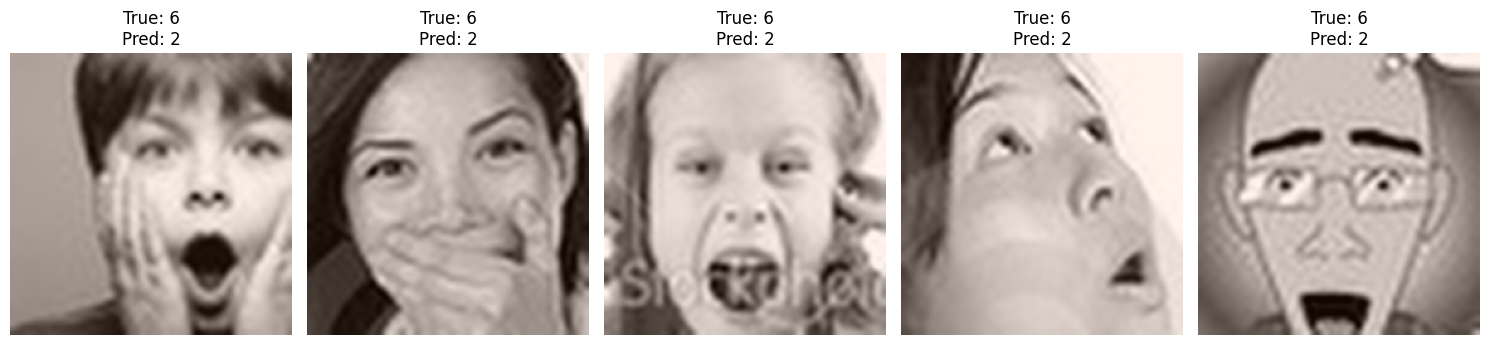

In [42]:
# Exibe os erros da classe "surprise" classificadas como "fear" do modelo Resnet50
show_images_with_classification_error(y_train_filtered, y_pred_rn50_classes, X_train_preprocessed, 6, 2, 5)

## Primeiras Conclusões

- O modelo **VGG19** apresentou desempenho superior em comparação ao **ResNet50**, mesmo ambos tendo sido treinados com o **mesmo dataset** e os **mesmos pré-processamentos**.
  
- Apesar da diferença geral de performance, **nenhum dos modelos foi capaz de prever corretamente imagens da classe _"surprise"_**, que foi majoritariamente confundida com a classe **"fear"**.

- O modelo **ResNet50** também apresentou dificuldades com a classe **"disgust"**, não conseguindo prever nenhuma instância corretamente. Por outro lado, o **VGG19** obteve **98,85% de acurácia** nessa mesma classe.

- Esses resultados sugerem que o **desbalanceamento entre as classes** pode estar impactando negativamente o desempenho dos modelos, especialmente nas classes menos representadas.
